In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('career_change_prediction_dataset.csv')

Saving career_change_prediction_dataset.csv to career_change_prediction_dataset.csv


In [3]:
# Drop unnecessary columns (if any)

# Display unique values in target column (debugging)
print("Unique values in target column:")
print(df['Likely to Change Occupation'].unique())

Unique values in target column:
[0 1]


In [4]:
# Ensure target column is integer type
y = df['Likely to Change Occupation'].astype('int64').values
X = df.drop(columns=['Likely to Change Occupation']).copy()


In [5]:
# Separate categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [6]:
# One-hot encode categorical
X_encoded = pd.get_dummies(X, columns=categorical_cols)

In [7]:
# Normalize numerical data
scaler = MinMaxScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

In [8]:
# Convert to numpy array
X = X_encoded.astype('float32').values

In [9]:
# Split data for federated learning
num_clients = 5
client_datasets = [(torch.tensor(X_split, dtype=torch.float32).unsqueeze(1), torch.tensor(y_split, dtype=torch.long))
                   for X_split, y_split in zip(np.array_split(X, num_clients), np.array_split(y, num_clients))]

In [10]:
# Attention GRU Model
class AttentionGRUModel(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(AttentionGRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, 128, batch_first=True, dropout=0.3, num_layers=2)
        self.attention = nn.Linear(128, 1)
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attention_weights = torch.softmax(self.attention(gru_out), dim=1)
        weighted_output = torch.sum(attention_weights * gru_out, dim=1)
        x = torch.relu(self.fc1(weighted_output))
        x = self.dropout(x)
        return self.fc2(x)


In [11]:
# Federated Training Preparation
models = [AttentionGRUModel(X.shape[1], num_classes=2) for _ in range(num_clients)]
optimizers = [optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5) for model in models]

In [12]:
# Training Process
NUM_ROUNDS = 100
train_loss = []

for round_num in range(NUM_ROUNDS):
    round_loss = 0.0
    for i, model in enumerate(models):
        optimizer = optimizers[i]
        optimizer.zero_grad()

        inputs, targets = client_datasets[i]
        outputs = model(inputs).squeeze()
        loss = nn.CrossEntropyLoss()(outputs, targets)
        loss.backward()
        optimizer.step()

        round_loss += loss.item()

    train_loss.append(round_loss / num_clients)
    print(f"Round {round_num + 1}, Loss: {train_loss[-1]:.4f}")

Round 1, Loss: 0.6939
Round 2, Loss: 0.6926
Round 3, Loss: 0.6914
Round 4, Loss: 0.6903
Round 5, Loss: 0.6891
Round 6, Loss: 0.6880
Round 7, Loss: 0.6870
Round 8, Loss: 0.6859
Round 9, Loss: 0.6849
Round 10, Loss: 0.6840
Round 11, Loss: 0.6831
Round 12, Loss: 0.6820
Round 13, Loss: 0.6812
Round 14, Loss: 0.6803
Round 15, Loss: 0.6792
Round 16, Loss: 0.6782
Round 17, Loss: 0.6774
Round 18, Loss: 0.6759
Round 19, Loss: 0.6749
Round 20, Loss: 0.6735
Round 21, Loss: 0.6724
Round 22, Loss: 0.6712
Round 23, Loss: 0.6695
Round 24, Loss: 0.6686
Round 25, Loss: 0.6672
Round 26, Loss: 0.6656
Round 27, Loss: 0.6641
Round 28, Loss: 0.6623
Round 29, Loss: 0.6599
Round 30, Loss: 0.6579
Round 31, Loss: 0.6552
Round 32, Loss: 0.6525
Round 33, Loss: 0.6494
Round 34, Loss: 0.6461
Round 35, Loss: 0.6426
Round 36, Loss: 0.6389
Round 37, Loss: 0.6348
Round 38, Loss: 0.6303
Round 39, Loss: 0.6265
Round 40, Loss: 0.6212
Round 41, Loss: 0.6160
Round 42, Loss: 0.6109
Round 43, Loss: 0.6043
Round 44, Loss: 0.59

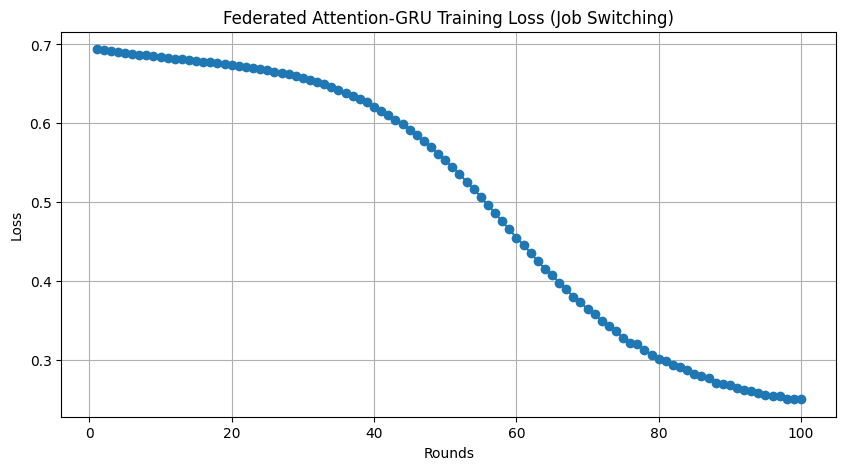

In [13]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_ROUNDS + 1), train_loss, marker='o')
plt.title('Federated Attention-GRU Training Loss (Job Switching)')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [14]:
# Model Evaluation
all_predictions = []
all_labels = []

for i, model in enumerate(models):
    inputs, targets = client_datasets[i]
    outputs = model(inputs)
    predictions = torch.argmax(outputs, dim=1)
    all_predictions.extend(predictions.tolist())
    all_labels.extend(targets.tolist())

In [15]:
# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9016
Precision: 0.9024
Recall: 0.9016
F1-Score: 0.9018


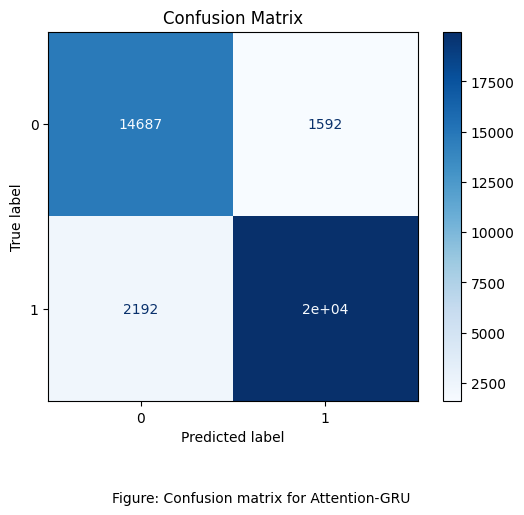

In [16]:
# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.figtext(0.5, -0.1, 'Figure: Confusion matrix for Attention-GRU',
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()